# Research Question 3: Random Forest Classifier

Here, we build a simple random forest classifier to classify hotel reviews
into two basic categories: those with negative and those with positive sentiment.

In [1]:
%matplotlib inline

import os 

# fundamentals
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None

# graphing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="talk", style="white")

# natural language processing
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

# turn a document to a vector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# machine learning imports
from funcsigs import signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    auc,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    f1_score
)

In [2]:
# import the data
DATADIR = os.path.join(os.path.abspath(os.path.dirname("")), "../../data")
DF = pd.read_csv(
    os.path.join(DATADIR, "combined_sentiments.csv"),
    header=0,
    sep=",",
    on_bad_lines="skip",
)
STOP = stopwords.words("english")


# lemmatise
def get_wordnet_pos(pos_tag):
    """lemmatises words by classifying them into their
    respective parts of speech."""
    if pos_tag.startswith("J"):
        return wordnet.ADJ
    elif pos_tag.startswith("V"):
        return wordnet.VERB
    elif pos_tag.startswith("N"):
        return wordnet.NOUN
    elif pos_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


def check_digits(text):
    """is there a digit in the text?"""
    return any(i.isdigit() for i in text)


def clean_review(review):
    """tokenise and clean up punctuation"""
    review = str(review).lower()
    review = [
        word.strip(string.punctuation) for word in review.split(" ")
    ]  # remove punctuation
    review = [
        word for word in review if not check_digits(word)
    ]  # remove digits

    # remove stop words
    review = [token for token in review if token not in STOP]

    # remove empty tokens
    review = [token for token in review if len(token) > 0]

    # tag each token with its part of speech (pos)
    pos_tags = pos_tag(review)
    review = [
        WordNetLemmatizer().lemmatize(tag[0], get_wordnet_pos(tag[1]))
        for tag in pos_tags
    ]

    # remove words with only one letter
    review = [token for token in review if len(token) > 1]
    review = " ".join(review)
    return review


# generate a cleaned, tokenised and lemmatised version of the reviews
DF["reviews.clean"] = DF["reviews.text"].apply(clean_review)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\geo\\Desktop\\repos\\pw23\\code\\old\\../../data\\combined_sentiments.csv'

In [ ]:
# extract vector representations for each review
DOCUMENTS = [
    TaggedDocument(doc, [i])
    for i, doc in enumerate(DF["reviews.clean"].apply(lambda x: x.split(" ")))
]

# train a doc2vec model
MODEL = Doc2Vec(
    DOCUMENTS,
    vector_size=5,
    window=2,
    min_count=1,
    workers=4,
)

# transform each document into vec data
DF_VEC = (
    DF["reviews.clean"]
    .apply(lambda x: MODEL.infer_vector(x.split(" ")))
    .apply(pd.Series)
)
DF_VEC.columns = ["vec_" + str(x) for x in DF_VEC.columns]
DF = pd.concat([DF, DF_VEC], axis=1)
# DF_VEC

# Term Frequency-Inverse Document Frequency (TF-IDF)

We can calculate the TF-IDF values of each review. This gives
us a list of values, denoting how often any token appears. We can use
these values as weights to determine how important a token is in determining
a review's overall sentiment.

In [ ]:
TFIDF = TfidfVectorizer(min_df=10)
tfidf_result = TFIDF.fit_transform(DF["reviews.clean"]).toarray()
DF_TFIDF = pd.DataFrame(tfidf_result, columns=TFIDF.get_feature_names_out())
DF_TFIDF.columns = ["word_" + str(x) for x in DF_TFIDF.columns]
DF_TFIDF.index = DF.index
DF = pd.concat([DF, DF_TFIDF], axis=1)
DF_TFIDF

,word_aaa,word_ability,word_able,word_absolute,word_absolutely,word_ac,word_accept,word_acceptable,word_access,word_accessible,...,word_yes,word_yet,word_yogurt,word_yolanda,word_york,word_you,word_young,word_yummy,word_zero,word_zoo
0,0.0,0.0,0.0,0.0,0.311162,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.169601,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Distribution

We can also examine how concentrated tokens of a specific sentiment score are by
plotting a simple histogram.

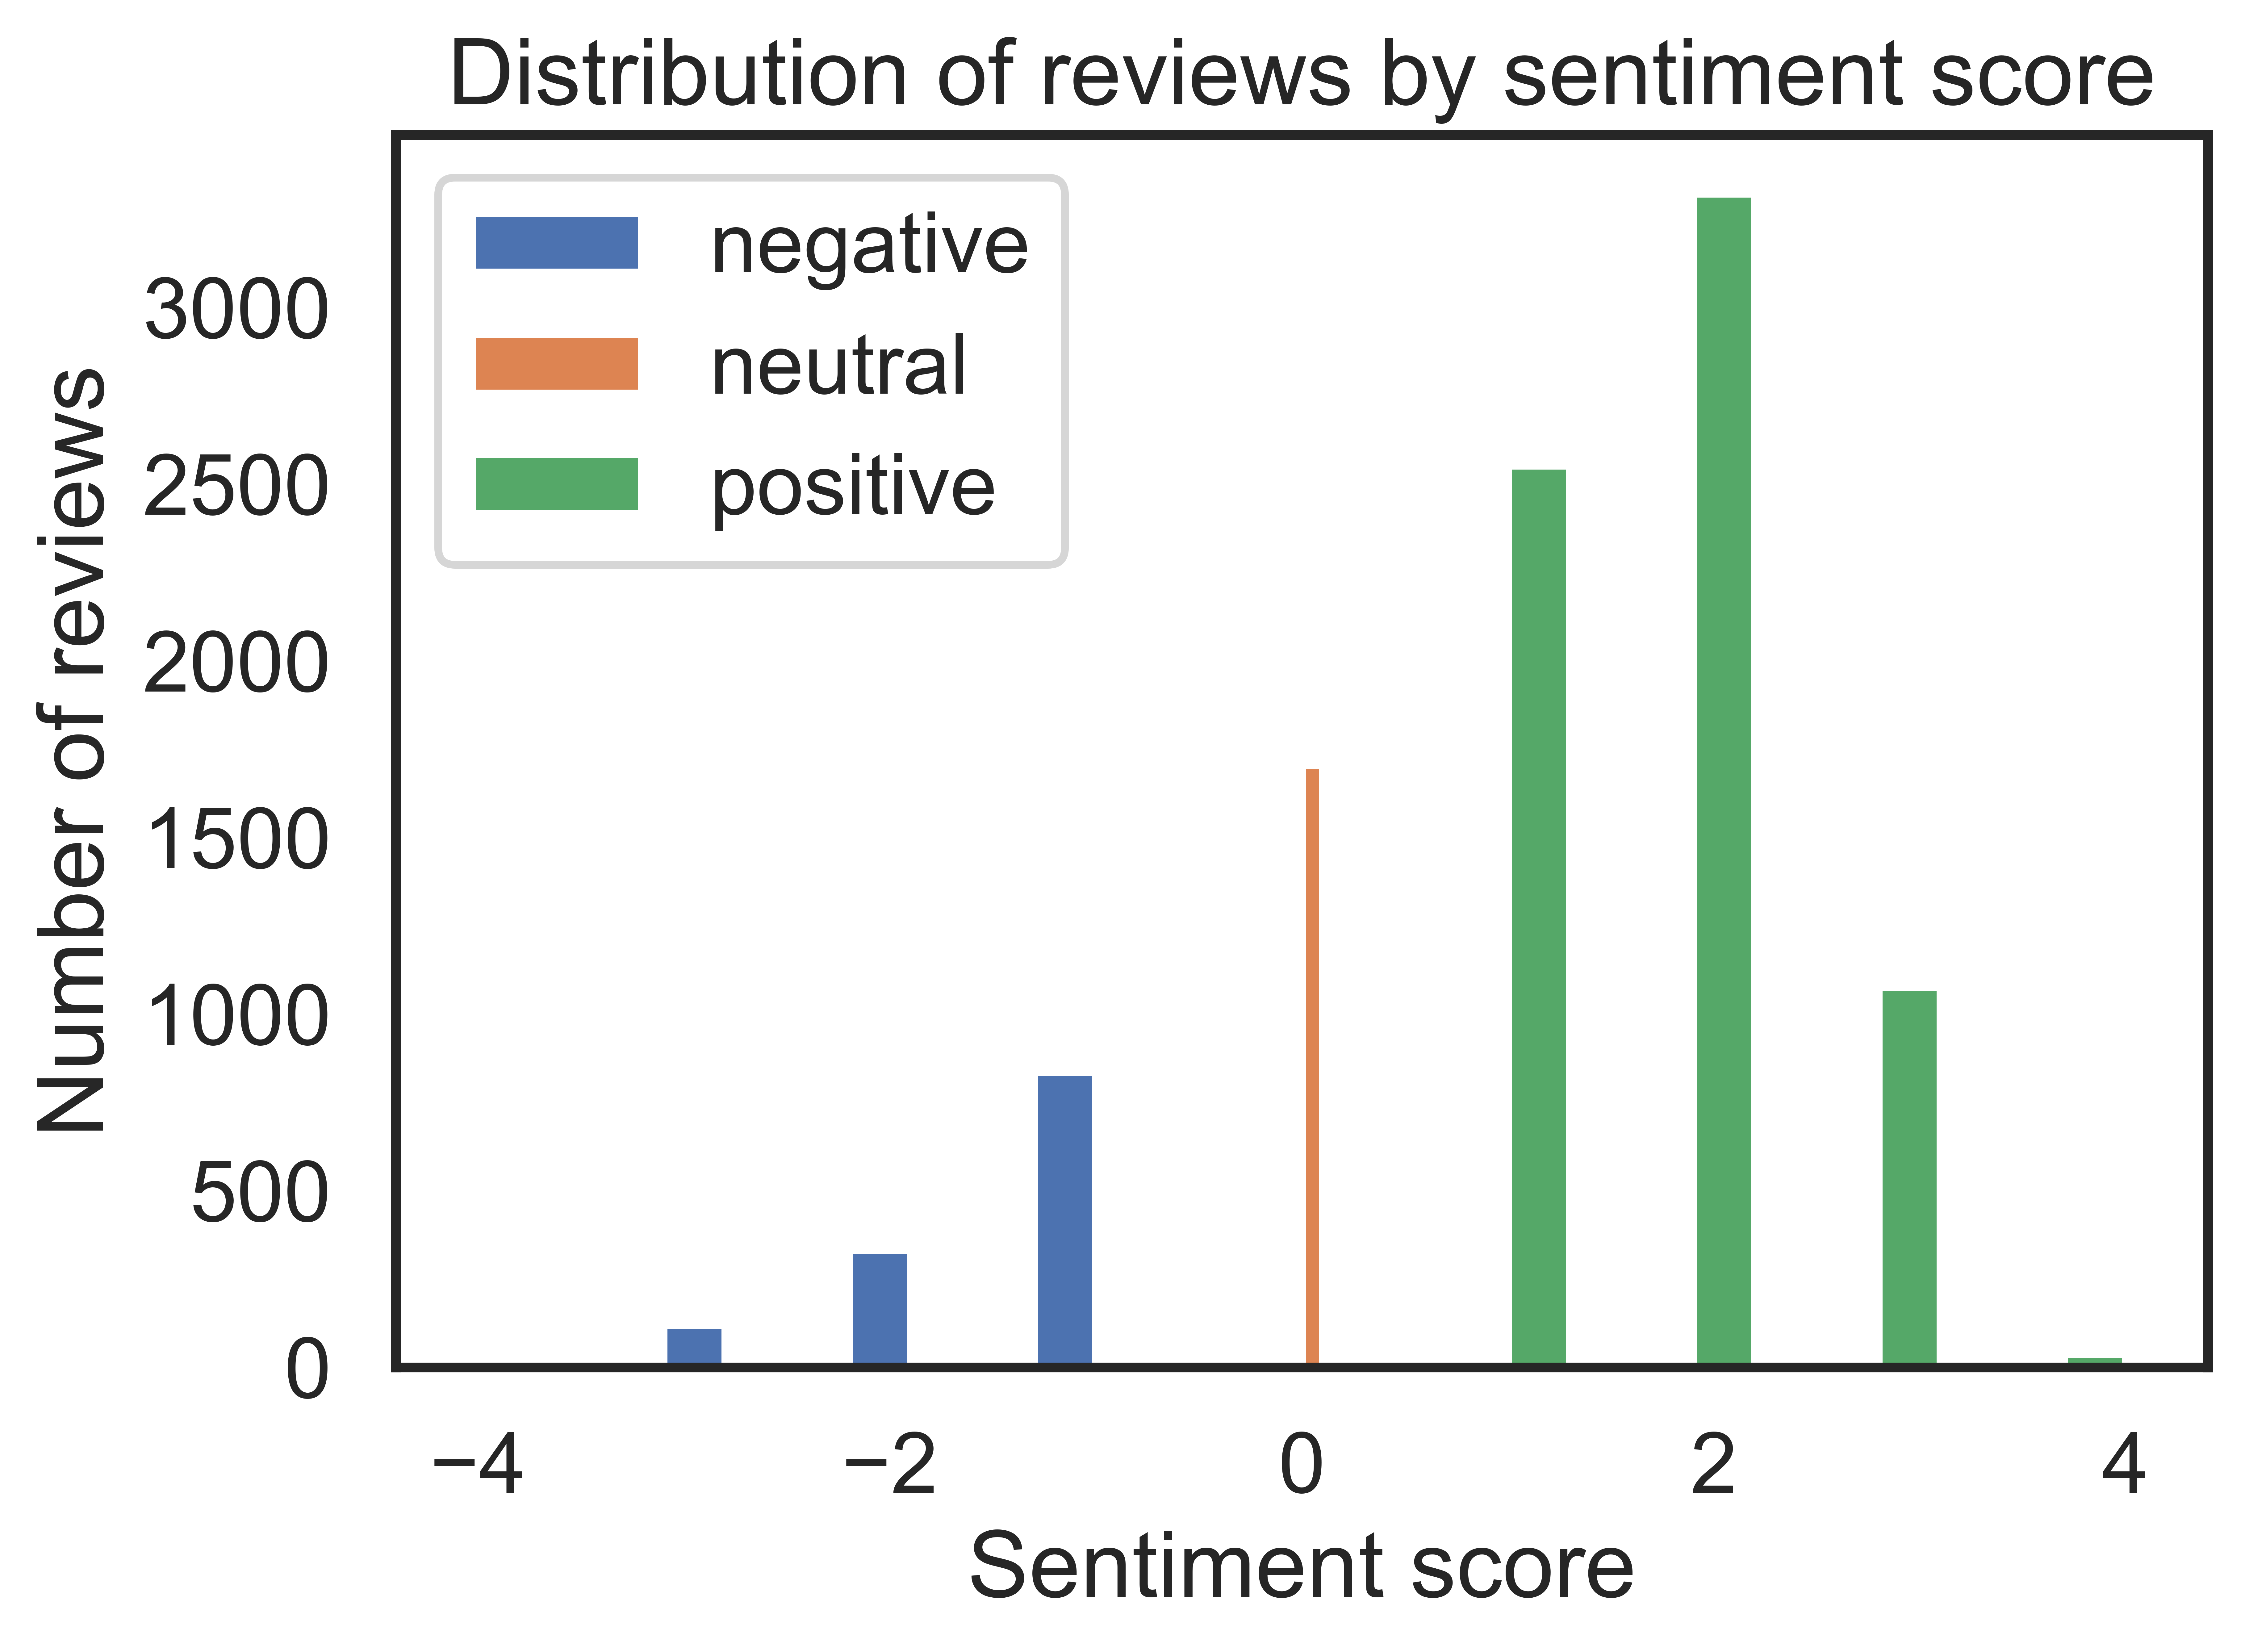

In [ ]:
RESULTSDIR = os.path.join(
    os.path.abspath(os.path.dirname("")),
    "../results/",
)
plt.title("Distribution of reviews by sentiment score")
plt.xlabel("Sentiment score")
plt.ylabel("Number of reviews")

SUBSET_NEG, SUBSET_NEU, SUBSET_POS = (
    DF[DF["sent.polarity"] == i] for i in list(range(-1, 2))
)
plt.hist(SUBSET_NEG["sent.net"], label="negative")
plt.hist(SUBSET_NEU["sent.net"], label="neutral")
plt.hist(SUBSET_POS["sent.net"], label="positive")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSDIR, "distribution.png"))

# Feature Selection

We can then select features we want to train our model on; we select two for
the independent and dependent variables respectively.

In [ ]:
DF["review.is_neg"] = DF["sent.polarity"].apply(lambda x: x == -1)
LABEL = "review.is_neg"
COLS_TO_IGNORE = [
    LABEL,
    "sent.polarity",
    "sent.pos",
    "sent.neg",
    "sent.net",
    "index",
    "reviews.rating",
    "reviews.clean",
    "reviews.title",
    "reviews.text",
]
FEATURES = [col for col in DF.columns if col not in COLS_TO_IGNORE]

"""split the data into training and testing sets."""
X_train, X_test, y_train, y_test = train_test_split(
    DF[FEATURES], DF[LABEL], test_size=0.2, random_state=42
)

# Real Meat

We finally can train our random forest classifier! Let's also examine
the feature importance the model has evaluated for us.

In [ ]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)

"""feature importance"""
FEATURE_IMPORTANCES = pd.DataFrame(
    {
        "feature": FEATURES,
        "importance": RF.feature_importances_,
    }
).sort_values("importance", ascending=False)

# Making Predictions

Let's get the model to make predictions. After that, we can plot the
**precision-recall** and **receiver operating characteristic** curves
to see how accurate the model is.

In [ ]:
y_pred = [pred[1] for pred in RF.predict_proba(X_test)]

## Receiver Operating Characteristic

We can compare the predictions with the original dataset to evaluate the
**true positive rate** and **false positive rate**. After that, we can
plot the true positive rate against the false positive rate to obtain a receiver
operating characteristic curve. The higher the curve lies over the dotted line
(where the true and false positive rates are equal), the more accurate
the predictions are.

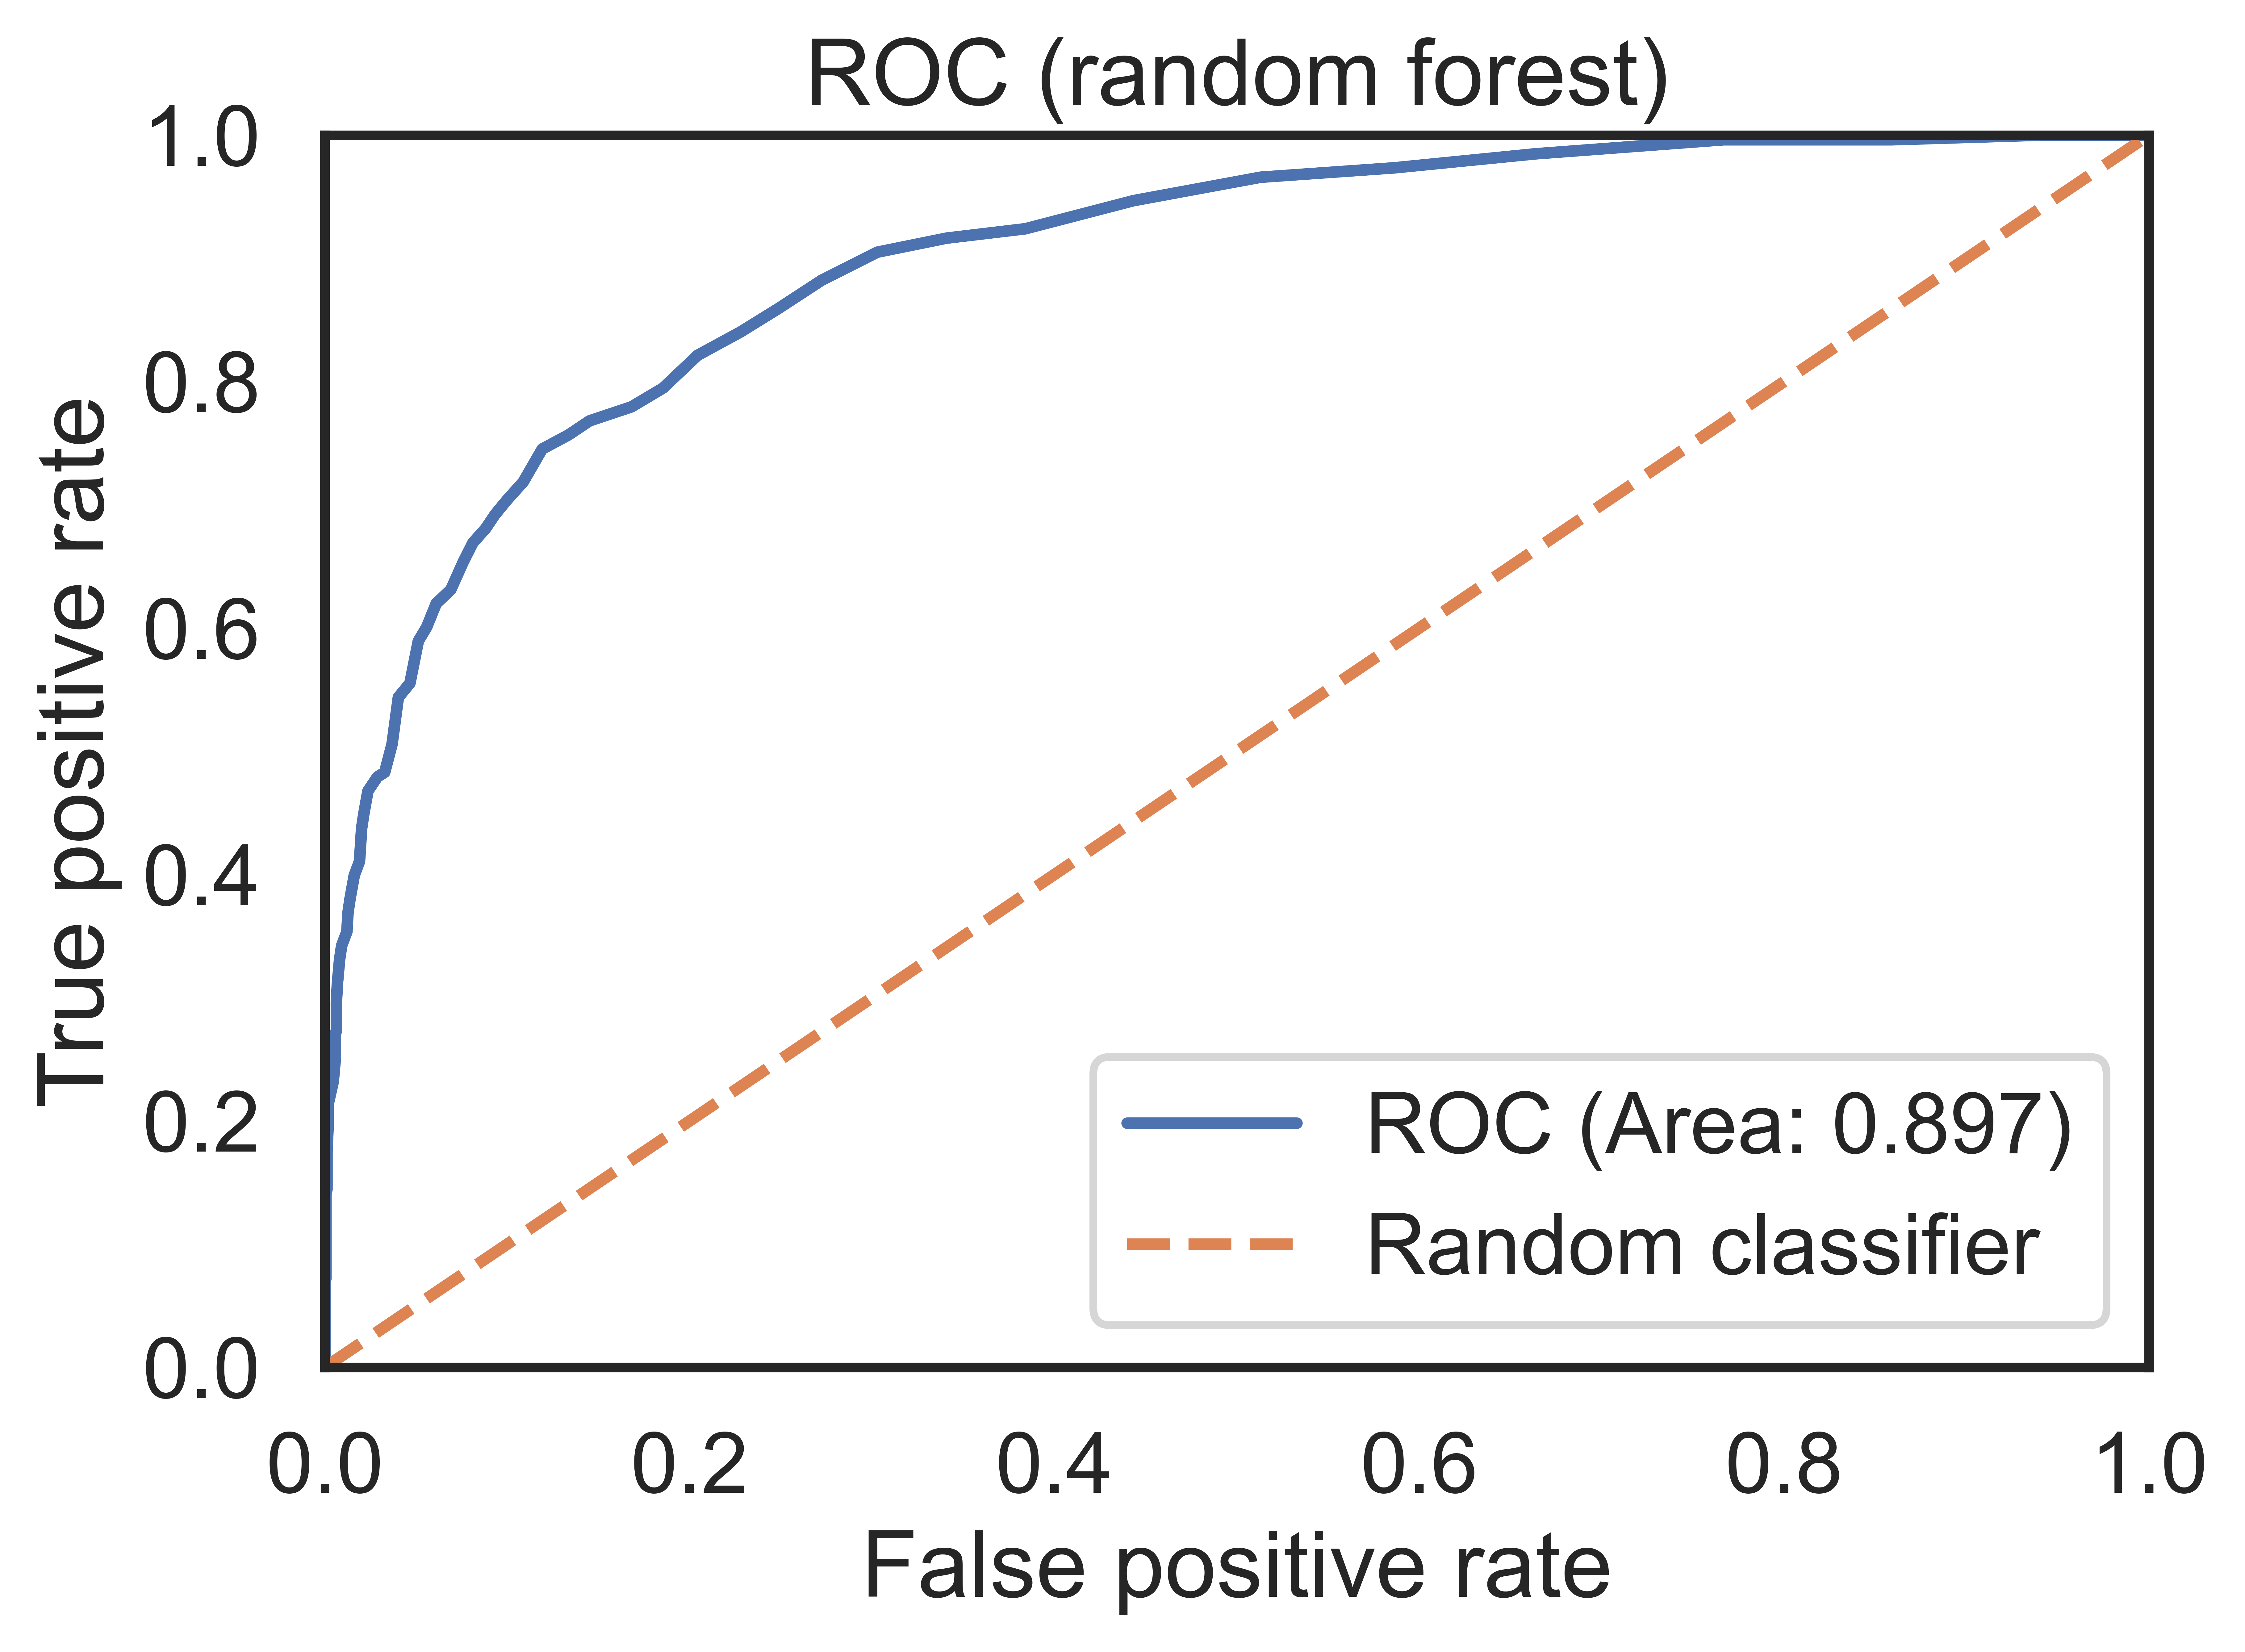

In [ ]:
FALSE_POS_RATE, TRUE_POS_RATE, thresholds = roc_curve(
    y_test, y_pred, pos_label=1
)
roc_auc = auc(FALSE_POS_RATE, TRUE_POS_RATE)

plt.plot(
    FALSE_POS_RATE,
    TRUE_POS_RATE,
    label=f"ROC (Area: {roc_auc:.3f})",
)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Random classifier",
)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.title("ROC (random forest)")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSDIR, "rndforst_roc.png"))

## Precision-Recall 

write some stuff!

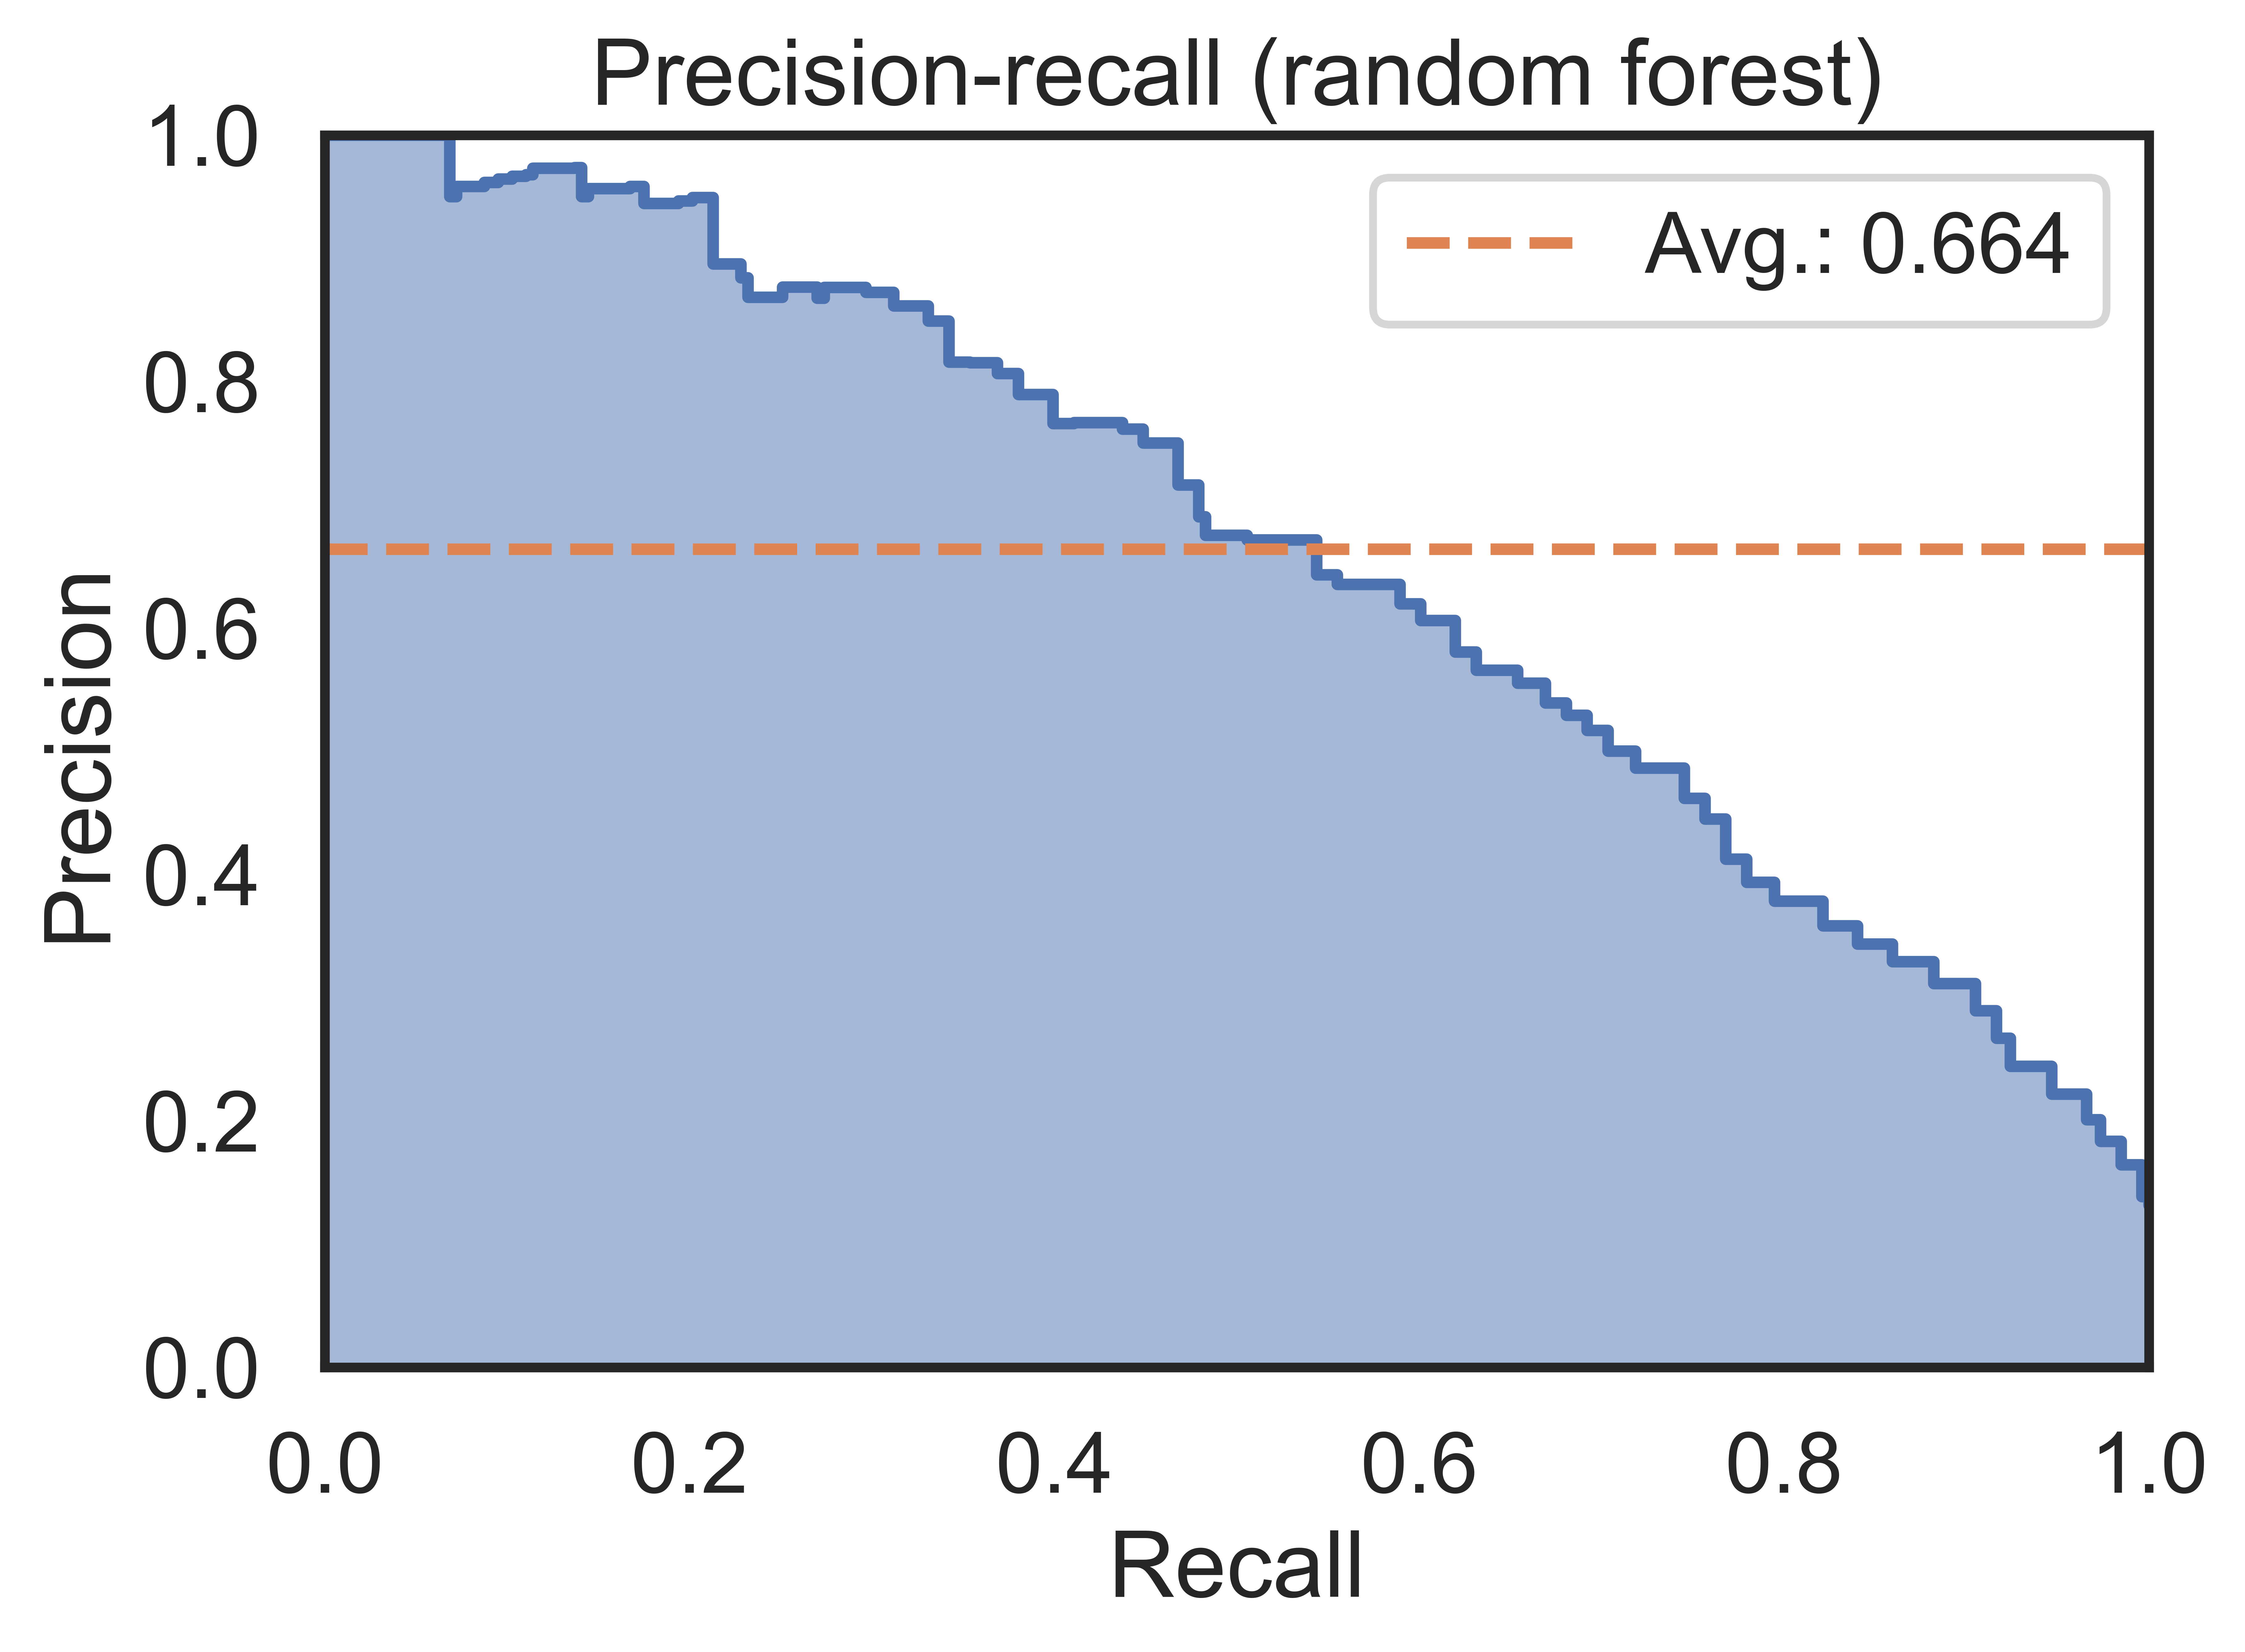

In [ ]:
AVG_PRECISION = average_precision_score(y_test, y_pred, pos_label=1)
PRECISION, RECALL, _ = precision_recall_curve(y_test, y_pred)
step_kwargs = (
    {"step": "post"} if "step" in signature(plt.fill_between).parameters else {}
)

plt.step(
    RECALL,
    PRECISION,
    where="post",
)
plt.fill_between(RECALL, PRECISION, alpha=0.5, **step_kwargs)
plt.axhline(
    y=AVG_PRECISION,
    label=f"Avg.: {AVG_PRECISION:.3f}",
    linestyle="--",
    color=(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.title("Precision-recall (random forest)")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSDIR, "rndforst_prc.png"))

# Confusion matrix

We plot the number of true and false positive predictions, as well as
the number of true and false negative predictions.

In [ ]:
y_pred_bin = np.where(
    np.array(y_pred) > np.median(y_pred), True, False
n)
confusion = confusion_matrix(y_test, y_pred_bin)
confusion

array([[1070,  667],
       [  20,  243]], dtype=int64)

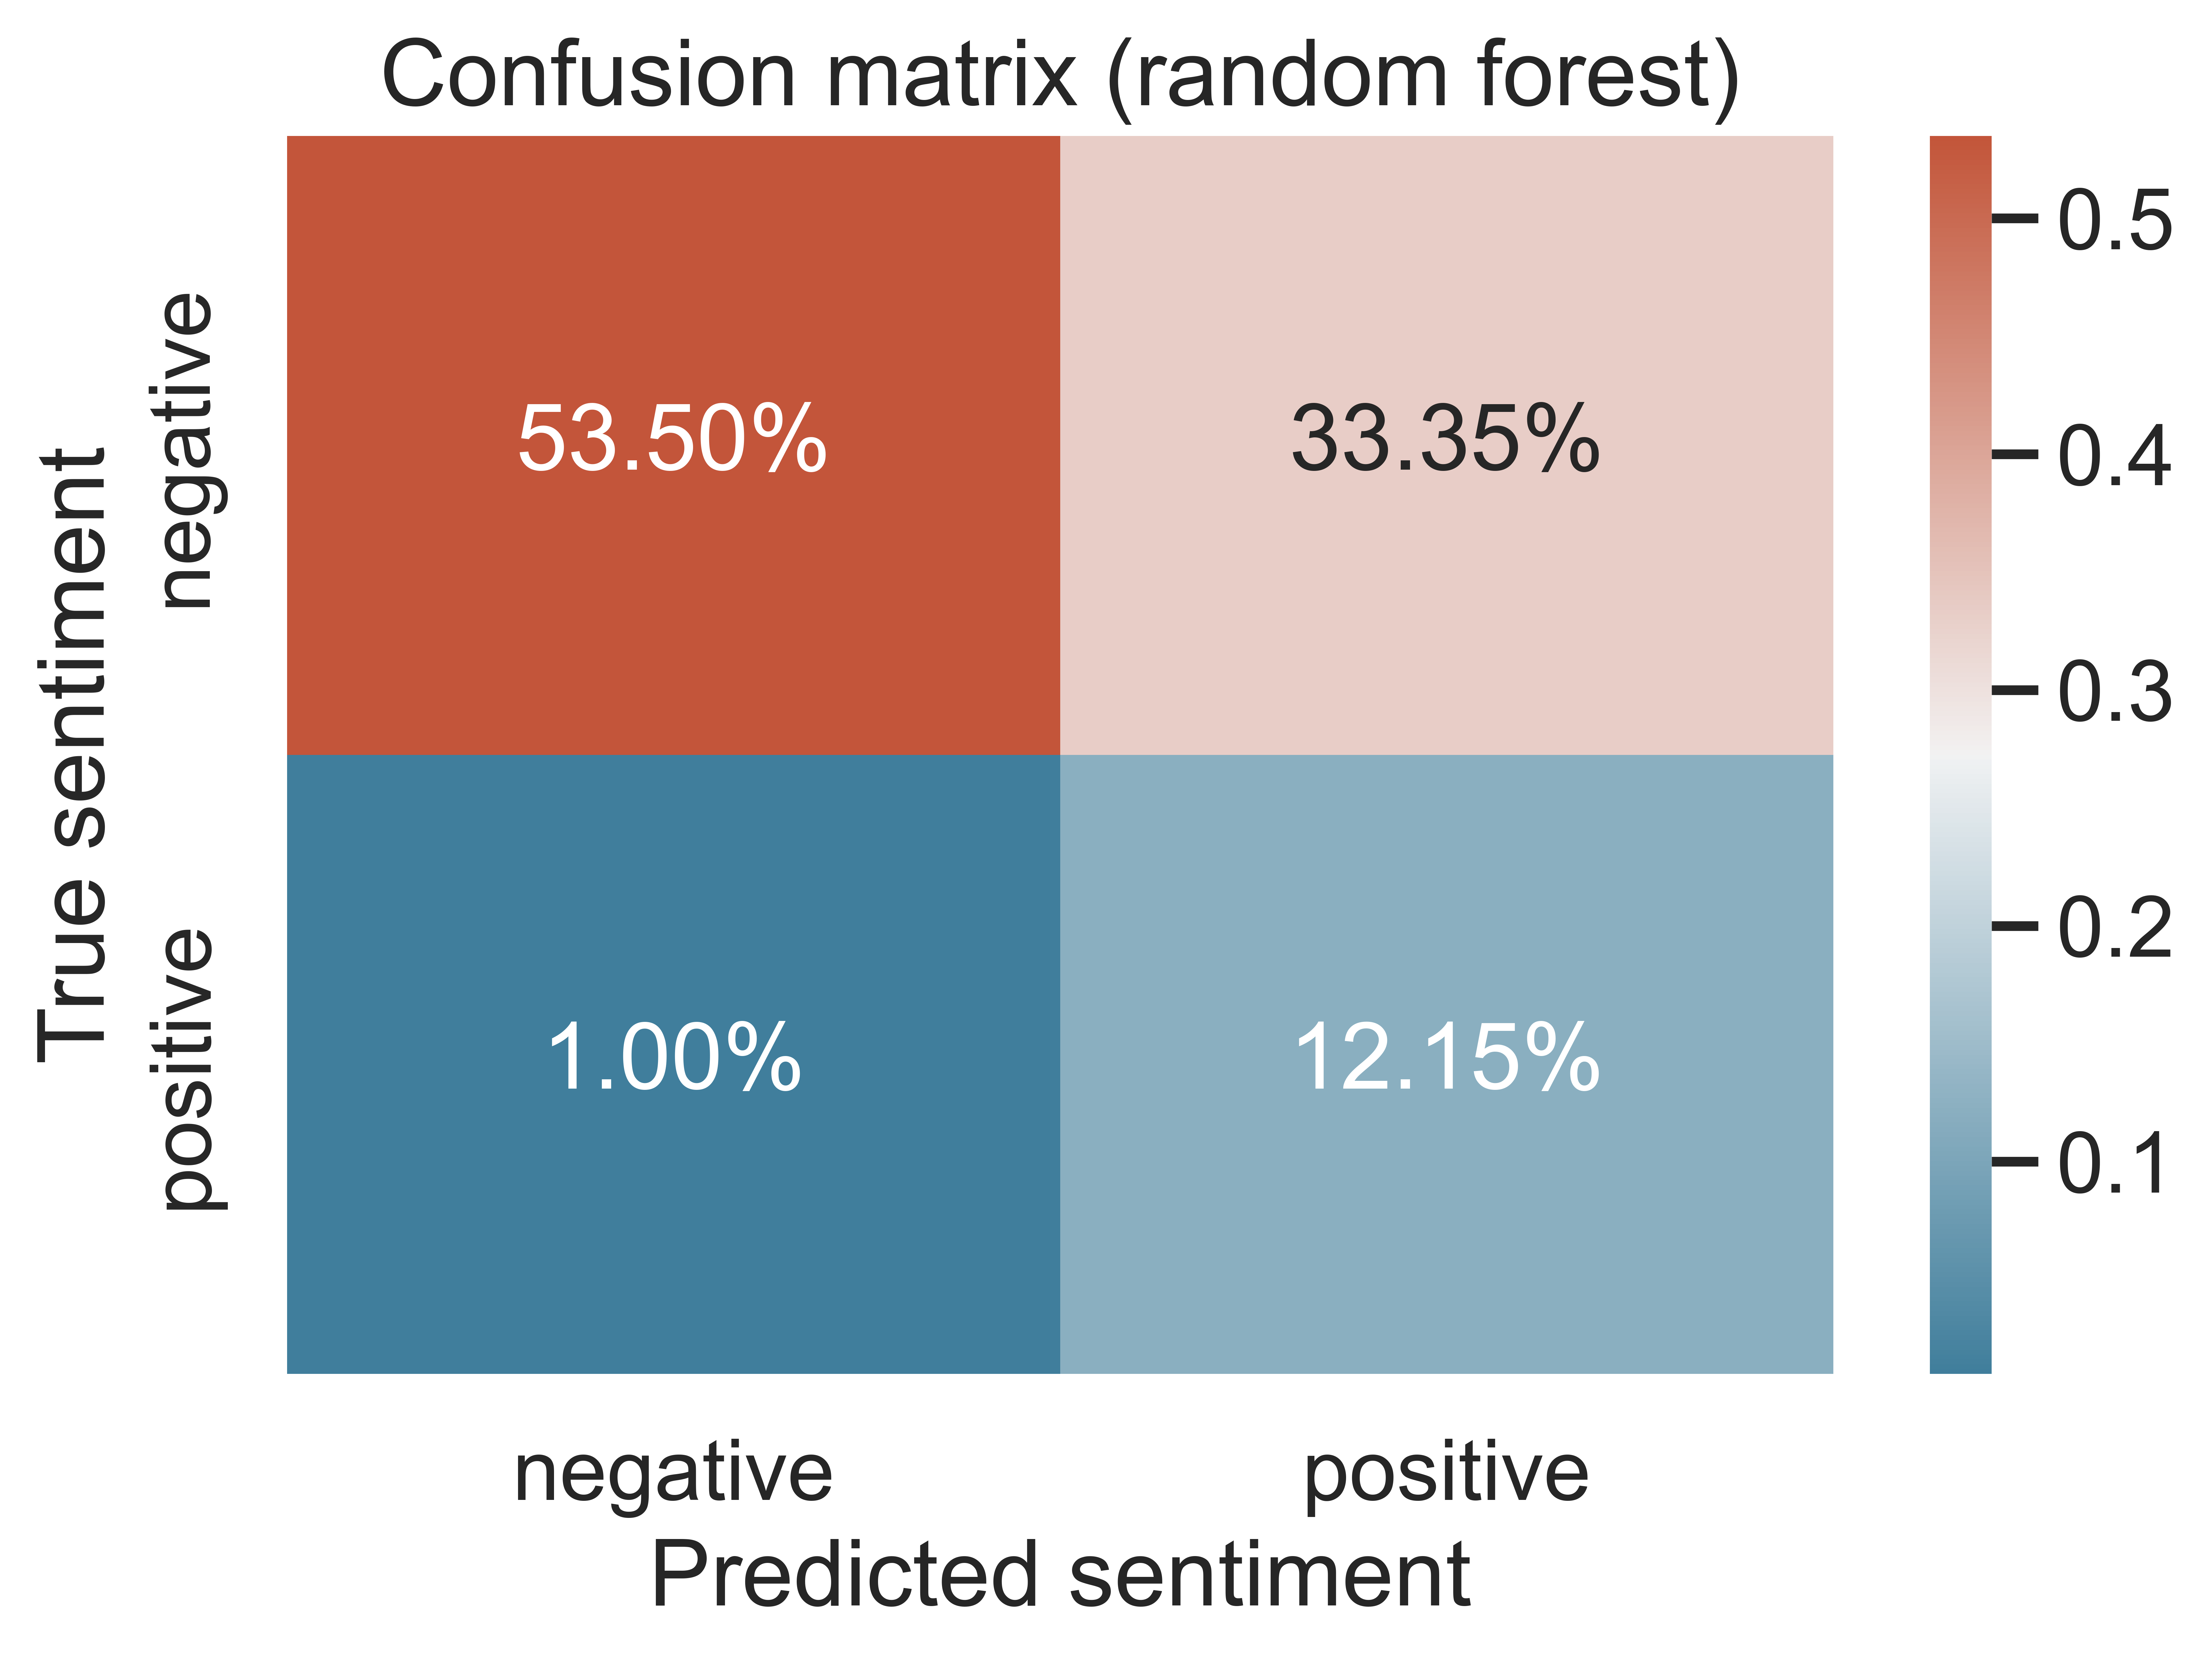

In [ ]:
sns.heatmap(
    confusion / np.sum(confusion),
    fmt=".2%",
    annot=True,
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    xticklabels=["negative", "positive"],
    yticklabels=["negative", "positive"],
)
plt.title("Confusion matrix (random forest)")
plt.xlabel("Predicted sentiment")
plt.ylabel("True sentiment")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSDIR, "rndforst_confuse.png"))

In [ ]:
f1_score(ACTUALS, PREDS)